### First off, here is a long-awaited answer to the question of whether we can group axis labels
It is possible, but require an extensive manual design

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist import SubplotHost


fig1 = plt.figure()
ax1 = SubplotHost(fig1, 111)
fig1.add_subplot(ax1)

# some data
x = np.arange(1, 6)
y = np.random.random(len(x))

# 1st x-axis
ax1.plot(x, y)
ax1.set_xticks(x)
ax1.set_xticklabels(['dog', 'cat', 'horse', 'lizard', 'crocodile'])
ax1.yaxis.set_label_text('measurement')

# 2nd x-axis
ax2 = ax1.twiny()
offset = 0, -25 # shift the second x-axis lower by 25 units
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis['bottom'] = new_axisline(loc = 'bottom', axes = ax2, offset = offset)

ax2.set_xticks([0.0, 0.6, 1.0]) ## define major tick locations = bracket range
ax2.xaxis.set_major_formatter(ticker.NullFormatter()) ## no label

ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.3, 0.8])) ## define minor tick locations = labels
ax2.axis['bottom'].minor_ticks.set_ticksize(0) ## set minor tick size to 0 = not displayed
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['mammal', 'reptiles'])) ##

# 3rd x-axis
ax3 = ax1.twiny()
offset = 0, -50 # shift the third x-axis lower by 50 units
new_axisline = ax3.get_grid_helper().new_fixed_axis
ax3.axis['bottom'] = new_axisline(loc = 'bottom', axes = ax3, offset = offset)

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.axis['bottom'].minor_ticks.set_ticksize(0)
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['vertebrates']))

ax1.grid(1)
plt.show()

# Let's explore linear models today

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import LinearSVR, SVR

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report

## First up is linear regression on psoas muscle dataset

In [2]:
data = pd.read_excel('3011979_datasets.xlsx', sheet_name = 'psoas_strength', index_col = 0)
data = data.loc[~pd.isna(data).any(axis = 1)]
data.head()

,Sex,Age,Ht,Wt,Rt/Lt,"Peak force, First (dominant)","Peak force, Second (dominant)","Duration/secs, First (dominant)","Duration/secs, Second (dominant)","Peak force, First (non-dominant)",...,"Psoas area, Rt","Psoas area, Lt","Psoas thickness, Rt","Psoas thickness, Lt","Psoas width, Rt","Psoas width, Lt","% fat, Rt","% fat, Lt",corridor length,anterior corridor
PatientID,,,,,,,,,,,,,,,,,,,,,
N001,M,55.0,1.70,74.0,Rt,18.5,21.9,4.6,6.6,14.6,...,18.987671,21.209954,4.912941,5.082353,5.336471,5.675294,4.802225,5.182677,0.882099,0.564706
N002,F,65.0,1.60,72.0,Rt,5.5,5.0,3.8,5.2,6.2,...,9.578674,10.210007,3.436490,2.854503,3.796767,4.960739,7.677740,14.800562,2.234000,-1.357968
N003,F,77.0,1.56,63.0,Rt,3.4,4.5,3.8,6.0,6.1,...,8.055383,9.994520,4.677494,4.621810,2.477958,3.368910,15.121444,22.372338,1.781250,0.974478
N004,M,57.0,1.60,68.0,Lt,7.5,14.0,5.6,4.0,11.1,...,18.072960,17.744915,4.613466,5.112219,5.336658,4.862843,6.362986,4.940156,1.539080,0.299252
N005,M,72.0,1.72,70.0,Lt,22.1,21.0,6.0,5.0,17.8,...,11.160336,13.229923,4.393204,4.563107,3.495146,4.296117,15.132093,11.006068,3.132949,-0.533981


In [3]:
print('data shape:', data.shape)

data shape: (205, 23)


## Separate input features and output labels
We will try to predict **Peak Force** using MRI features

In [4]:
output_data = data[['Peak force, First (dominant)', 'Peak force, Second (dominant)']].mean(axis = 1).copy()
raw_input_data = data[['Sex', 'Age', 'Ht', 'Wt', 'Rt/Lt', 'corridor length', 'anterior corridor']].copy()

for f in ['Psoas area', 'Psoas thickness', 'Psoas width', '% fat']:
    raw_input_data[f] = data[[f + ', Rt', f + ', Lt']].mean(axis = 1)
    
display(raw_input_data.head(2))
display(output_data.head(2))

,Sex,Age,Ht,Wt,Rt/Lt,corridor length,anterior corridor,Psoas area,Psoas thickness,Psoas width,% fat
PatientID,,,,,,,,,,,
N001,M,55.0,1.7,74.0,Rt,0.882099,0.564706,20.098812,4.997647,5.505882,4.992451
N002,F,65.0,1.6,72.0,Rt,2.234000,-1.357968,9.894340,3.145497,4.378753,11.239151


PatientID
N001    20.20
N002     5.25
dtype: float64

## Convert categorical features to {0,1} encoding (one-hot)

In [5]:
input_data = raw_input_data.copy()

temp = pd.get_dummies(input_data['Sex'], prefix = 'Sex')
temp = pd.concat([input_data, temp], axis = 1)
input_data = temp.drop(['Sex', 'Sex_M'], axis = 1)

temp = pd.get_dummies(input_data['Rt/Lt'], prefix = 'Dominant')
temp = pd.concat([input_data, temp], axis = 1)
input_data = temp.drop(['Rt/Lt', 'Dominant_R', 'Dominant_Rt'], axis = 1)

input_data.tail()

,Age,Ht,Wt,corridor length,anterior corridor,Psoas area,Psoas thickness,Psoas width,% fat,Sex_F,Dominant_Lt
PatientID,,,,,,,,,,,
N218,75.0,1.56,51.0,1.313817,-0.103044,8.384039,3.606557,3.168618,6.151771,1,0
N219,58.0,1.60,75.0,1.140307,0.415704,11.724208,4.295612,3.782910,9.460528,1,0
N220,55.0,1.65,61.0,0.842551,-0.339806,7.897775,4.332524,2.791262,10.019254,1,0
N221,63.0,1.60,53.0,1.274876,-0.454988,10.707599,4.054745,3.827251,7.119755,1,1
N222,51.0,1.48,76.0,1.463321,-0.304850,10.080399,3.658199,3.769053,13.860140,1,0


## Different ways to split data
train_test_split *without stratification*

In [6]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2,
                                                    random_state = 3011979)

print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)
print('train data % female:', X_train['Sex_F'].sum() / X_train.shape[0])
print('test data % female:', X_test['Sex_F'].sum() / X_test.shape[0])

train data shape: (164, 11)
test data shape: (41, 11)
train data % female: 0.6829268292682927
test data % female: 0.7317073170731707


train_test_split *with stratification*

In [7]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2,
                                                    stratify = input_data['Sex_F'],
                                                    random_state = 3011979)

print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)
print('train data % female:', X_train['Sex_F'].sum() / X_train.shape[0])
print('test data % female:', X_test['Sex_F'].sum() / X_test.shape[0])

train data shape: (164, 11)
test data shape: (41, 11)
train data % female: 0.6951219512195121
test data % female: 0.6829268292682927


## k-fold cross-validation
KFold and StratifiedKFold

In [ ]:
splitter = KFold(n_splits = 5, shuffle = True, random_state = 3011979)

for train_indices, test_indices in splitter.split(input_data):
    print('train size:', train_indices.shape, 'test size:', test_indices.shape)

In [ ]:
splitter = KFold(n_splits = 5, shuffle = True, random_state = 21556447)

for train_indices, test_indices in splitter.split(input_data):
    print('train size:', train_indices.shape, 'test size:', test_indices.shape)

### More splits lead to smaller test/validation size

In [ ]:
splitter = KFold(n_splits = 10, shuffle = True, random_state = 3011979)

for train_indices, test_indices in splitter.split(input_data):
    print('train size:', train_indices.shape, 'test size:', test_indices.shape)

### Stratified split lets you fix data composition

In [8]:
splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 3011979)

for train_indices, test_indices in splitter.split(input_data, input_data['Sex_F']):
    X_train = input_data.iloc[train_indices]
    X_test = input_data.iloc[test_indices]
    y_train = output_data.iloc[train_indices]
    y_test = output_data.iloc[test_indices]
    
    print('train % female:', X_train['Sex_F'].sum() / X_train.shape[0], 'test % female:', X_test['Sex_F'].sum() / X_test.shape[0])

train % female: 0.6951219512195121 test % female: 0.6829268292682927
train % female: 0.6951219512195121 test % female: 0.6829268292682927
train % female: 0.6951219512195121 test % female: 0.6829268292682927
train % female: 0.6890243902439024 test % female: 0.7073170731707317
train % female: 0.6890243902439024 test % female: 0.7073170731707317


## With bootstrapping, you can freely control the fraction of test/validation set
ShuffleSplit and StraifiedShuffleSplit 

In [9]:
splitter = ShuffleSplit(n_splits = 10, test_size = 0.4, random_state = 3011979)

for train_indices, test_indices in splitter.split(input_data):
    print('train size:', train_indices.shape, 'test size:', test_indices.shape)

train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)
train size: (123,) test size: (82,)


# Let's do a train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2,
                                                    random_state = 3011979)

## Standardize data using mean and SD estimates from the training set

In [11]:
X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
y_scaler = StandardScaler(with_mean = True, with_std = True).fit(y_train.values.reshape([-1, 1]))

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

y_train_std = y_scaler.transform(y_train.values.reshape([-1, 1]))
y_test_std = y_scaler.transform(y_test.values.reshape([-1, 1]))

In [12]:
X_train_std.head()

,Age,Ht,Wt,corridor length,anterior corridor,Psoas area,Psoas thickness,Psoas width,% fat,Sex_F,Dominant_Lt
PatientID,,,,,,,,,,,
N160,-1.012929,0.556957,0.174442,0.024660,-0.403822,0.327395,0.030213,0.306677,-0.263012,-1.467599,-0.372678
N199,1.445511,-0.834022,0.174442,0.800761,-0.784018,-0.889400,-1.027803,-0.438944,1.684701,0.681385,-0.372678
N020,0.532377,-0.602192,0.621568,-0.029535,-0.597385,-0.276784,-0.299332,0.111226,1.326791,0.681385,-0.372678
N016,-0.099794,0.556957,1.739381,0.673840,0.417246,0.228826,0.503942,0.061260,-0.267141,0.681385,-0.372678
N123,0.251412,-0.486277,-1.166933,-0.460473,-1.133660,-0.705709,-1.255622,-0.096508,1.113901,0.681385,-0.372678


## Define basic linear regression, Ridge, and LASSO model

In [13]:
base_linear = LinearRegression()
base_ridge = Ridge(alpha = 1.0, random_state = 3011979)
base_lasso = Lasso(alpha = 1.0, random_state = 3011979)

## Fit the model to training data 

In [14]:
base_linear = base_linear.fit(X_train_std, y_train_std)
base_ridge = base_ridge.fit(X_train_std, y_train_std)
base_lasso = base_lasso.fit(X_train_std, y_train_std)

## Make prediction and evaluate performance

In [15]:
base_linear_pred = base_linear.predict(X_test_std)
base_ridge_pred = base_ridge.predict(X_test_std)
base_lasso_pred = base_lasso.predict(X_test_std)

In [16]:
print('linear regression MSE:', mean_squared_error(y_test_std, base_linear_pred))
print('Ridge regression MSE:', mean_squared_error(y_test_std, base_ridge_pred))
print('Lasso regression MSE:', mean_squared_error(y_test_std, base_lasso_pred))

linear regression MSE: 0.6520188726335454
Ridge regression MSE: 0.6434040311845903
Lasso regression MSE: 0.7651371828473389


## View the model coefficients

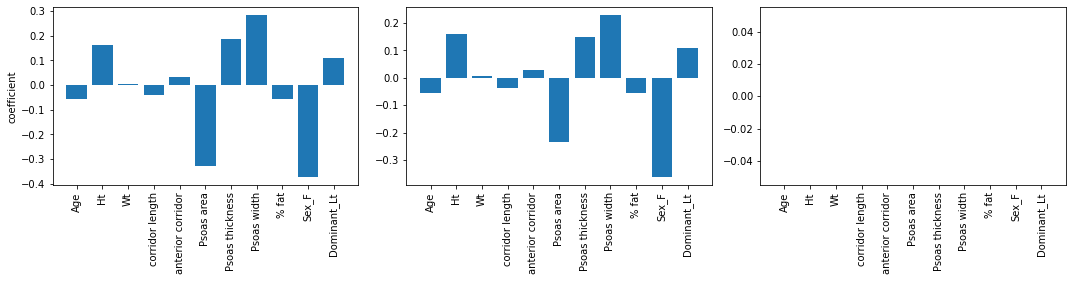

In [17]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1)
plt.bar(range(X_train_std.shape[1]), base_linear.coef_[0])
plt.xticks(range(X_train_std.shape[1]), labels = X_train_std.columns, rotation = 90)
plt.ylabel('coefficient')

plt.subplot(1, 3, 2)
plt.bar(range(X_train_std.shape[1]), base_ridge.coef_[0])
plt.xticks(range(X_train_std.shape[1]), labels = X_train_std.columns, rotation = 90)

plt.subplot(1, 3, 3)
plt.bar(range(X_train_std.shape[1]), base_lasso.coef_)
plt.xticks(range(X_train_std.shape[1]), labels = X_train_std.columns, rotation = 90)

plt.tight_layout()
plt.show()

## The Lasso model just predicts the mean value!
This is probably because **alpha = 1.0** is too high

Lasso regression MSE: 0.6312330684128491


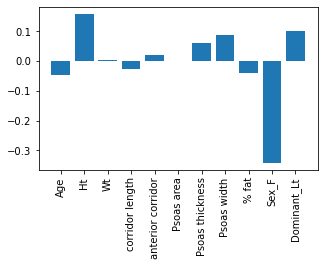

In [21]:
base_lasso = Lasso(alpha = 0.01, random_state = 3011979)
base_lasso = base_lasso.fit(X_train_std, y_train_std)
base_lasso_pred = base_lasso.predict(X_test_std)
print('Lasso regression MSE:', mean_squared_error(y_test_std, base_lasso_pred))

plt.figure(figsize = (5, 3))
plt.bar(range(X_train_std.shape[1]), base_lasso.coef_)
plt.xticks(range(X_train_std.shape[1]), labels = X_train_std.columns, rotation = 90)
plt.show()

## Is MSE of 0.6414 good or bad?
Baseline = predict mean value

In [ ]:
print('baseline MSE:', mean_squared_error(y_test_std, np.zeros(y_test_std.shape) + y_train_std.mean()))

### Scatter plots

In [ ]:
plt.figure(figsize = (5, 5))
plt.scatter(y_train_std, base_lasso.predict(X_train_std), label = 'Lasso model, training')
plt.scatter(y_test_std, base_lasso_pred, label = 'Lasso model, test')
plt.xlabel('ground truth'); plt.ylabel('predicted')
plt.legend()
plt.plot([-1.6, 2.1], [-1.6, 2.1], '--k')
plt.show()

## Support Vector Machine with Radial Basis Function (RBF) kernel
Explore the impact of **C** (inverse regularization weight) and **epsilon** (allowed regression error)

In [22]:
def fit_rbf(C, epsilon):
    svm_rbf = SVR(C = C, epsilon = epsilon, kernel = 'rbf')
    svm_rbf = svm_rbf.fit(X_train_std, y_train_std.ravel())
    svm_rbf_pred = svm_rbf.predict(X_test_std)

    plt.scatter(y_train_std, svm_rbf.predict(X_train_std), label = 'RBF SVM, training')
    plt.scatter(y_test_std, svm_rbf_pred, label = 'RBF SVM, test')
    plt.xlabel('ground truth'); plt.ylabel('predicted')
    plt.legend()
    plt.plot([-1.6, 2.1], [-1.6, 2.1], '--k')
    plt.title('C: ' + str(C) + ', epsilon: ' + str(epsilon) + 
              ', MSE: ' +  str(mean_squared_error(y_test_std, svm_rbf_pred))[:6])

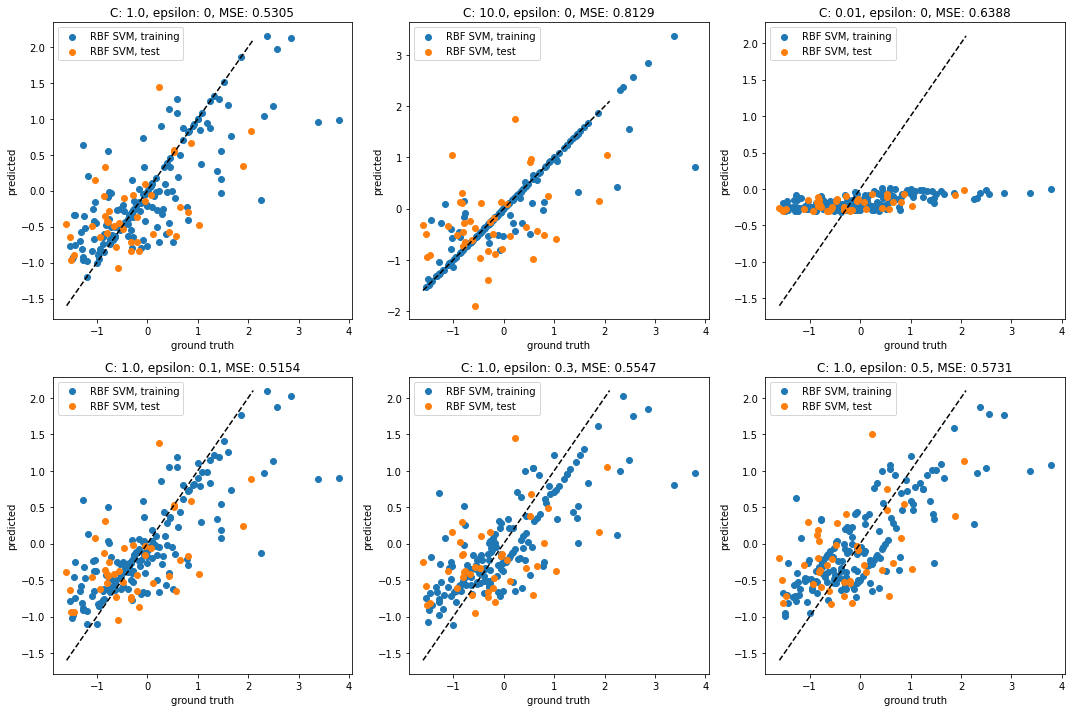

In [23]:
params = [[1.0, 0], [10.0, 0], [0.01, 0],
          [1.0, 0.1], [1.0, 0.3], [1.0, 0.5]]

plt.figure(figsize = (15, 10))

for i, p in enumerate(params, start = 1):
    plt.subplot(2, 3, i)
    fit_rbf(p[0], p[1])

plt.tight_layout()
plt.show()

## The best MSE is 0.5154. How does this translate to the original data unit?
MSE = (y - f(x))^2 --> scaled by std(y)^2

In [ ]:
print('original-scale MSE:', 0.5154 * (y_train.std() ** 2))

# Let's do a stratified bootstrap with the best SVM model
Record MSE from 10 bootstraps

In [ ]:
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 3011979)
tuned_svm_rbf = SVR(C = 1.0, epsilon = 0.1, kernel = 'rbf')
tuned_svm_rbf_mse = []

for train_indices, test_indices in splitter.split(input_data, input_data['Sex_F']):
    X_train = input_data.iloc[train_indices]
    X_test = input_data.iloc[test_indices]
    y_train = output_data.iloc[train_indices]
    y_test = output_data.iloc[test_indices]
    
    X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
    y_scaler = StandardScaler(with_mean = True, with_std = True).fit(y_train.values.reshape([-1, 1]))

    X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

    y_train_std = y_scaler.transform(y_train.values.reshape([-1, 1]))
    y_test_std = y_scaler.transform(y_test.values.reshape([-1, 1]))
    
    tuned_svm_rbf = tuned_svm_rbf.fit(X_train_std, y_train_std.ravel())
    y_pred = tuned_svm_rbf.predict(X_test_std)
    tuned_svm_rbf_mse.append(mean_squared_error(y_test_std, y_pred))
    
print('MSE:', tuned_svm_rbf_mse)
print('average:', np.mean(tuned_svm_rbf_mse), 'sd:', np.std(tuned_svm_rbf_mse))

### What about Lasso model?
We can also collect coefficients

In [ ]:
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 3011979)
tuned_lasso = Lasso(alpha = 0.001, random_state = 3011979)
tuned_lasso_mse = []
tuned_lasso_coeff = []

for train_indices, test_indices in splitter.split(input_data, input_data['Sex_F']):
    X_train = input_data.iloc[train_indices]
    X_test = input_data.iloc[test_indices]
    y_train = output_data.iloc[train_indices]
    y_test = output_data.iloc[test_indices]
    
    X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
    y_scaler = StandardScaler(with_mean = True, with_std = True).fit(y_train.values.reshape([-1, 1]))

    X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

    y_train_std = y_scaler.transform(y_train.values.reshape([-1, 1]))
    y_test_std = y_scaler.transform(y_test.values.reshape([-1, 1]))
    
    tuned_lasso = tuned_lasso.fit(X_train_std, y_train_std.ravel())
    y_pred = tuned_lasso.predict(X_test_std)
    tuned_lasso_mse.append(mean_squared_error(y_test_std, y_pred))
    tuned_lasso_coeff.append(tuned_lasso.coef_)
    
print('MSE:', tuned_lasso_mse)
print('average:', np.mean(tuned_lasso_mse), 'sd:', np.std(tuned_lasso_mse))

### Compare MSE between the corresponding bootstrap

In [ ]:
plt.figure(figsize = (5, 5))
plt.scatter(tuned_svm_rbf_mse, tuned_lasso_mse)
plt.plot([0.5, 1.2], [0.5, 1.2], '--k')
plt.xlabel('SVM MSE'); plt.ylabel('Lasso MSE')
plt.show()

### View Lasso coefficients

In [ ]:
coeffs = np.concatenate(tuned_lasso_coeff).reshape([-1, X_train.shape[1]])

plt.figure(figsize = (6, 4))
plt.boxplot([coeffs[:, i] for i in range(coeffs.shape[1])])
plt.plot([0.5, X_train_std.shape[1] + 0.5], [0, 0], '--k')
plt.xticks(range(1, X_train_std.shape[1] + 1), labels = X_train_std.columns, rotation = 90)
plt.show()

# Next, let's do some binary classification
We will use **leaf_absorbance** data

In [ ]:
data = pd.read_excel('3011979_datasets.xlsx', sheet_name = 'leaf_absorbance', index_col = None)
data = data.loc[~pd.isna(data).any(axis = 1)]
data.head()

## Separate input and output data

In [ ]:
output_data = data['ConditionID']
input_data = data.iloc[:, 3:]

print('input data shape:', input_data.shape)

## A train-test split with stratification on Cultivar ID
Also standardized data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2,
                                                    stratify = data['CultivarID'], random_state = 3011979)

X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

## Try Logistic regression and SVM

In [ ]:
base_l2_logistic = LogisticRegression(penalty = 'l2', C = 1.0, random_state = 3011979, 
                                      max_iter = 10000).fit(X_train_std, y_train)
base_l1_logistic = LogisticRegression(penalty = 'l1', C = 10.0, random_state = 3011979, 
                                      solver = 'liblinear', max_iter = 10000).fit(X_train_std, y_train)
base_linear_svm = LinearSVC(C = 1.0, random_state = 3011979).fit(X_train_std, y_train.ravel())
base_rbf_svm = SVC(C = 1.0, kernel = 'rbf').fit(X_train_std, y_train.ravel())

print('L2 logistic acc:', accuracy_score(y_test, base_l2_logistic.predict(X_test_std)))
print('L1 logistic acc:', accuracy_score(y_test, base_l1_logistic.predict(X_test_std)))
print('SVM acc:', accuracy_score(y_test, base_linear_svm.predict(X_test_std)))
print('RBF SVM acc:', accuracy_score(y_test, base_rbf_svm.predict(X_test_std)))

## Ready-to-use classification report

In [ ]:
print(classification_report(y_test, base_l1_logistic.predict(X_test_std)))